In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
# Load model and thresholds
xgb_model_001_with_thresholds = joblib.load("xgboost_model_with_thresholds.pkl")
best_xgb_001 = xgb_model_001_with_thresholds["model"]
best_thresholds = xgb_model_001_with_thresholds["thresholds"]

print("Model and thresholds loaded successfully!")



Model and thresholds loaded successfully!


In [14]:
import pandas as pd

# Load train and test sets
X_train = pd.read_csv("X_train_selected_001.csv")
X_test = pd.read_csv("X_test_selected_001.csv")
Y_train = pd.read_csv("Y_train.csv")
Y_test = pd.read_csv("Y_test.csv")

print("All datasets loaded successfully!")


All datasets loaded successfully!


In [15]:
# Convert Y to numpy arrays for TensorFlow
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Get input and output dimensions
input_dim = X_train.shape[1]  # Number of features
output_dim = Y_train.shape[1]  # Number of labels (16)

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (80-20 split)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)

# Multi-Layer Perceptron (MLP)

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, accuracy_score


In [7]:
# Custom F1-Score Metric
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary labels (0 or 1)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)  # Macro F1-Score

# Custom Hamming Loss Metric
def hamming_loss_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary
    return tf.reduce_mean(tf.cast(tf.not_equal(y_true, y_pred), tf.float32))

In [9]:
# Define model architecture
mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),  # First hidden layer
    Dropout(0.3),
    Dense(128, activation='relu'),   # Second hidden layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(output_dim, activation='sigmoid')  # Multi-label classification (sigmoid for probability output)
])

# Compile model
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Suitable for multi-label classification
    metrics=['accuracy', f1_metric, hamming_loss_metric]
)

In [10]:
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mlp_model.fit(
    X_train_final, Y_train_final,
    epochs=50,  
    batch_size=32,  
    validation_data=(X_val, Y_val),  # Use validation set instead of test set
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2813 - f1_metric: 0.0920 - hamming_loss_metric: 0.0727 - loss: 0.1781 - val_accuracy: 0.3773 - val_f1_metric: 0.1867 - val_hamming_loss_metric: 0.0353 - val_loss: 0.0918
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3845 - f1_metric: 0.1827 - hamming_loss_metric: 0.0347 - loss: 0.0921 - val_accuracy: 0.4077 - val_f1_metric: 0.2386 - val_hamming_loss_metric: 0.0308 - val_loss: 0.0811
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4248 - f1_metric: 0.2180 - hamming_loss_metric: 0.0303 - loss: 0.0800 - val_accuracy: 0.4632 - val_f1_metric: 0.2560 - val_hamming_loss_metric: 0.0282 - val_loss: 0.0762
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4902 - f1_metric: 0.2326 - hamming_loss_metric: 0.0289 - loss: 0.0755 - val_accuracy: 0.5330 - val_f1_metric: 0.2550 - val_hamming_loss_metric: 0.0269 - val_loss: 0.0722
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - ac

# MLP 1 Result

In [11]:
# Predict probabilities using the final model on test data
Y_pred_probs = mlp_model.predict(X_test)  # Now X_test is used only for final evaluation

# Convert probabilities to binary (default threshold 0.5)
Y_pred = (Y_pred_probs >= 0.5).astype(int)

# Compute final evaluation metrics
hamming = hamming_loss(Y_test, Y_pred)
f1_macro = f1_score(Y_test, Y_pred, average="macro", zero_division=0)
f1_micro = f1_score(Y_test, Y_pred, average="micro", zero_division=0)
accuracy = accuracy_score(Y_test, Y_pred)

# Print final test results
print("\n🔹 MLP Model Test Results:")
print(f"Hamming Loss: {hamming:.5f}")
print(f"F1-Score (Macro): {f1_macro:.5f}")
print(f"F1-Score (Micro): {f1_micro:.5f}")
print(f"Accuracy: {accuracy:.5f}")

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step

🔹 MLP Model Test Results:
Hamming Loss: 0.02508
F1-Score (Macro): 0.47954
F1-Score (Micro): 0.80345
Accuracy: 0.73583


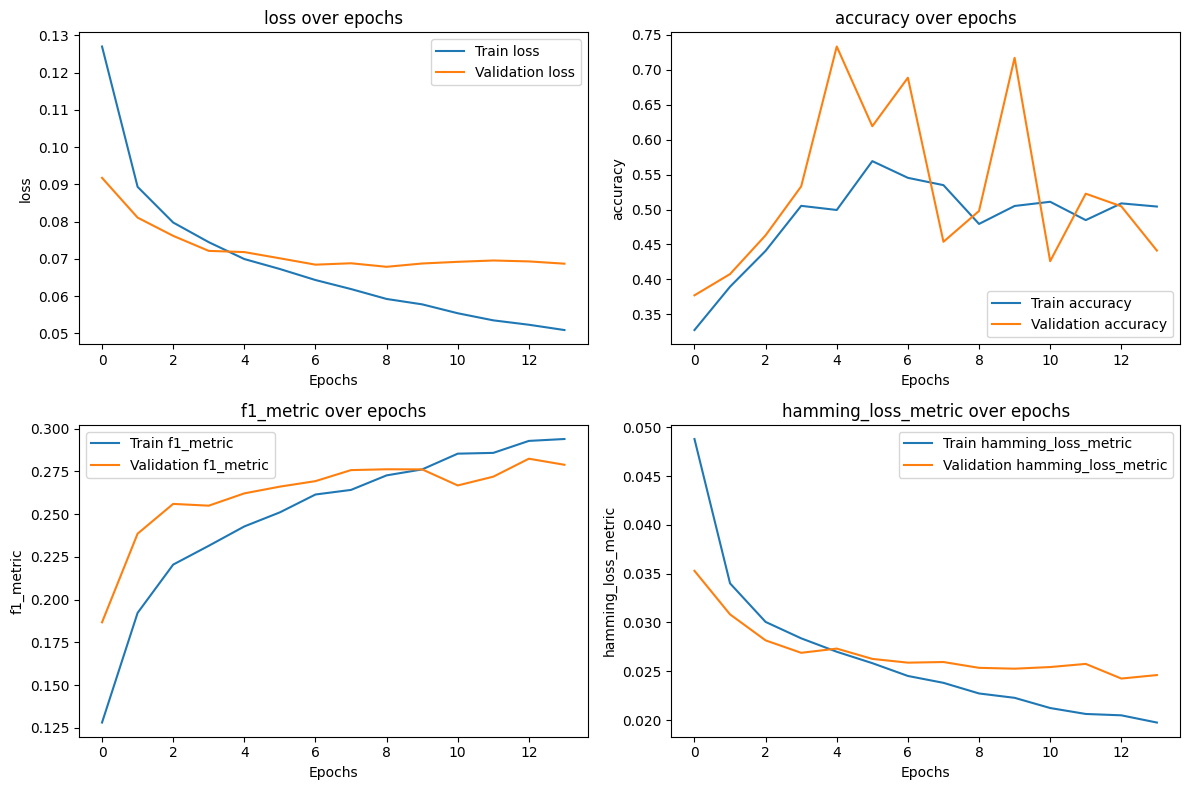

In [12]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    metrics = ["loss", "accuracy", "f1_metric", "hamming_loss_metric"]
    val_metrics = ["val_" + metric for metric in metrics]

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        if metric in history.history and val_metrics[i] in history.history:
            plt.subplot(2, 2, i+1)
            plt.plot(history.history[metric], label=f"Train {metric}")
            plt.plot(history.history[val_metrics[i]], label=f"Validation {metric}")
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.title(f"{metric} over epochs")
            plt.legend()
        else:
            print(f"Warning: {metric} or {val_metrics[i]} not found in history.")

    plt.tight_layout()
    plt.show()

# Call the function with the model's training history
plot_training_history(history)



The training curves indicate a **gradual improvement** in performance, but also suggest **possible overfitting**. The **loss curve** (top-left) shows that while the training loss is continuously decreasing, the validation loss plateaus after a few epochs and slightly fluctuates, which might indicate that the model is struggling to generalize. The **accuracy plot** (top-right) shows some instability, especially in validation accuracy, suggesting that the model's performance varies significantly across different validation batches. The **F1-score plot** (bottom-left) shows a steady increase in both training and validation sets, but the validation F1-score stops improving after a certain point, reinforcing the overfitting concern. Finally, the **Hamming loss** (bottom-right) consistently decreases, which is a positive sign, but the gap between training and validation indicates that the model might be memorizing patterns from the training data rather than generalizing well. To mitigate overfitting, consider **adding regularization (e.g., L2, dropout), tuning hyperparameters, or using early stopping more aggressively.**

# GridSearch MLP


In [13]:
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

# Function to build the model for tuning
def build_model(hp):
    model = Sequential([
        Dense(hp.Int('units_1', min_value=256, max_value=512, step=128), activation='relu',
              kernel_regularizer=l2(hp.Choice('l2_1', values=[0.0001, 0.0005, 0.001]))),
        Dropout(hp.Choice('dropout_1', values=[0.2, 0.3])),
        
        Dense(hp.Int('units_2', min_value=128, max_value=256, step=64), activation='relu',
              kernel_regularizer=l2(hp.Choice('l2_2', values=[0.0001, 0.0005, 0.001]))),
        Dropout(hp.Choice('dropout_2', values=[0.2, 0.3])),
        
        Dense(Y_train.shape[1], activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.002])),
        loss='binary_crossentropy',
        metrics=['accuracy', f1_metric, hamming_loss_metric]
    )

    return model

# Set up hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_tuning',
    project_name='mlp_tuning',
    overwrite=True  # Ensures it doesn't load old results
)

# Define early stopping for tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    X_train_final, Y_train_final,
    epochs=30,
    validation_data=(X_val, Y_val),  # Use validation split, NOT X_test
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print("\n✅ Best Hyperparameters Found:")
print(f"🔹 Units (Layer 1): {best_hp.get('units_1')}")
print(f"🔹 L2 Regularization (Layer 1): {best_hp.get('l2_1')}")
print(f"🔹 Dropout (Layer 1): {best_hp.get('dropout_1')}")
print(f"🔹 Units (Layer 2): {best_hp.get('units_2')}")
print(f"🔹 L2 Regularization (Layer 2): {best_hp.get('l2_2')}")
print(f"🔹 Dropout (Layer 2): {best_hp.get('dropout_2')}")
print(f"🔹 Learning Rate: {best_hp.get('learning_rate')}")



Trial 90 Complete [00h 00m 46s]
val_loss: 0.09407433867454529

Best val_loss So Far: 0.08299069851636887
Total elapsed time: 00h 17m 17s

✅ Best Hyperparameters Found:
🔹 Units (Layer 1): 384
🔹 L2 Regularization (Layer 1): 0.0001
🔹 Dropout (Layer 1): 0.2
🔹 Units (Layer 2): 128
🔹 L2 Regularization (Layer 2): 0.0001
🔹 Dropout (Layer 2): 0.2
🔹 Learning Rate: 0.0005


# Best MLP

In [16]:
# ✅ Define Best MLP Model with Tuned Hyperparameters
best_mlp_model = Sequential([
    Dense(384, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),  # Layer 1
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),  # Layer 2
    Dropout(0.2),

    Dense(output_dim, activation='sigmoid')  # Multi-label classification output
])

# Compile model with best learning rate
best_mlp_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Tuned Learning Rate
    loss='binary_crossentropy',
    metrics=['accuracy', f1_metric, hamming_loss_metric]
)

# ✅ Define EarlyStopping (Monitor Validation Loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# ✅ Train the best model using the validation set
history_best = best_mlp_model.fit(
    X_train_final, Y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),  # ✅ Corrected Validation Set
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2745 - f1_metric: 0.1034 - hamming_loss_metric: 0.0670 - loss: 0.2237 - val_accuracy: 0.3743 - val_f1_metric: 0.2053 - val_hamming_loss_metric: 0.0334 - val_loss: 0.1202
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3781 - f1_metric: 0.1918 - hamming_loss_metric: 0.0353 - loss: 0.1223 - val_accuracy: 0.3815 - val_f1_metric: 0.2164 - val_hamming_loss_metric: 0.0308 - val_loss: 0.1061
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3909 - f1_metric: 0.2120 - hamming_loss_metric: 0.0310 - loss: 0.1062 - val_accuracy: 0.4201 - val_f1_metric: 0.2322 - val_hamming_loss_metric: 0.0287 - val_loss: 0.0971
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4056 - f1_metric: 0.2250 - hamming_loss_metric: 0.0288 - loss: 0.0973 - val_accuracy: 0.4174 - val_f1_metric: 0.2262 - val_hamming_loss_metric: 0.0285 - val_loss: 0.0933
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4

In [17]:
# ✅ Predict probabilities using the final model on test data
Y_pred_probs_best = best_mlp_model.predict(X_test)

# Convert probabilities to binary (default threshold 0.5)
Y_pred_best = (Y_pred_probs_best >= 0.5).astype(int)

# ✅ Compute final evaluation metrics on the **test set**
hamming_best = hamming_loss(Y_test, Y_pred_best)
f1_macro_best = f1_score(Y_test, Y_pred_best, average="macro", zero_division=0)
f1_micro_best = f1_score(Y_test, Y_pred_best, average="micro", zero_division=0)
accuracy_best = accuracy_score(Y_test, Y_pred_best)

# ✅ Print final test results
print("\n✅ Best MLP Model Test Results:")
print(f"🔹 Hamming Loss: {hamming_best:.5f}")
print(f"🔹 F1-Score (Macro): {f1_macro_best:.5f}")
print(f"🔹 F1-Score (Micro): {f1_micro_best:.5f}")
print(f"🔹 Accuracy: {accuracy_best:.5f}")

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step

✅ Best MLP Model Test Results:
🔹 Hamming Loss: 0.02397
🔹 F1-Score (Macro): 0.48027
🔹 F1-Score (Micro): 0.81587
🔹 Accuracy: 0.73963


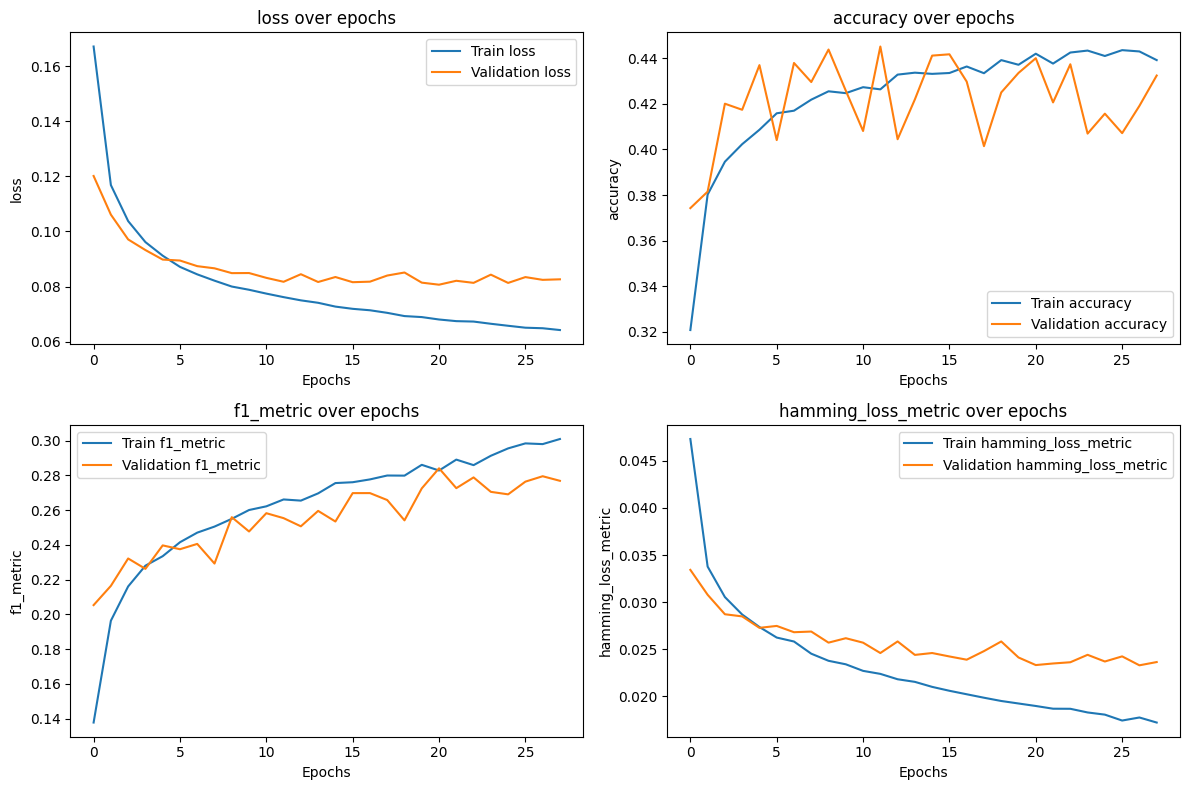

In [18]:
plot_training_history(history_best)

The **best model's performance** appears well-balanced, with **improved generalization** and **controlled overfitting**. The **loss curve** (top-left) shows that both training and validation loss decrease smoothly, with a slight gap, indicating good learning without excessive regularization. The **accuracy curve** (top-right) demonstrates a steady increase, with validation accuracy following a similar trend, though slightly more volatile, which is expected in real-world scenarios. The **F1-score (bottom-left)** consistently improves for both training and validation, confirming better multi-label classification performance. The **Hamming loss (bottom-right)** decreases steadily, with validation loss staying close to the training loss, suggesting that the model is not overfitting and is learning effectively. Overall, **this model is well-optimized, achieving a strong balance between learning and generalization**, making it a **significant improvement over previous versions**. 🚀

In [19]:
best_mlp_model.save("best_mlp_model.h5")

print("Best model saved successfully!")


Best model saved successfully!


In [ ]:
import torch

from pytorch_tabnet.tab_model import TabNetClassifier


# Convert X_train and X_test to NumPy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

# Convert Y_train and Y_test to PyTorch tensors (for multi-label classification)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32)

# Train TabNet with corrected format
tabnet_model = TabNetClassifier()
tabnet_model.fit(X_train_np, Y_train_torch, eval_set=[(X_test_np, Y_test_torch)], patience=7)



In [ ]:


# Get predictions from TabNet
Y_pred_probs_tabnet = tabnet_model.predict_proba(X_test_np)  # Predict probabilities

# Convert probabilities to binary (default threshold 0.5)
Y_pred_tabnet = (Y_pred_probs_tabnet >= 0.5).astype(int)

# Compute evaluation metrics
hamming_tabnet = hamming_loss(Y_test, Y_pred_tabnet)
f1_macro_tabnet = f1_score(Y_test, Y_pred_tabnet, average="macro", zero_division=0)
f1_micro_tabnet = f1_score(Y_test, Y_pred_tabnet, average="micro", zero_division=0)
accuracy_tabnet = accuracy_score(Y_test, Y_pred_tabnet)

print("\n🔹 TabNet Model Results:")
print(f"Hamming Loss: {hamming_tabnet:.5f}")
print(f"F1-Score (Macro): {f1_macro_tabnet:.5f}")
print(f"F1-Score (Micro): {f1_micro_tabnet:.5f}")
print(f"Accuracy: {accuracy_tabnet:.5f}")


Why?

TabNet uses attention mechanisms to focus on the most important features.
It performs feature selection implicitly, reducing noise from unnecessary features.
Works well on categorical and binary data.

# Autoencoder + MLP (Feature Reduction + Classification) 

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, accuracy_score


# ✅ Split training data into train and validation sets (80-20 split)
X_train_auto, X_val_auto, Y_train_auto, Y_val_auto = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)


In [25]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# Define autoencoder structure
input_dim = X_train.shape[1]  # 340 features
encoding_dim = 100  # Reduce features to 100

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder (only for reconstruction, not used in classification)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Binary-friendly loss

# ✅ Train Autoencoder using validation set
early_stopping_autoencoder = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder_history = autoencoder.fit(
    X_train_auto, X_train_auto,  # Train autoencoder to reconstruct X_train_auto
    epochs=50,
    batch_size=32,
    validation_data=(X_val_auto, X_val_auto),  # Validation using X_val_auto
    callbacks=[early_stopping_autoencoder],
    verbose=1
)

# ✅ Extract compressed features correctly (Fixes mismatch)
encoder = Model(input_layer, encoded)  # Keep only the encoder part
X_train_encoded_auto = encoder.predict(X_train_auto)  # ✅ Now encodes only split data
X_val_encoded_auto = encoder.predict(X_val_auto)  # ✅ Correct validation set
X_test_encoded_auto = encoder.predict(X_test)  # ✅ Test set remains untouched






Epoch 1/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3521 - val_loss: 0.1695
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1501 - val_loss: 0.1105
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1011 - val_loss: 0.0850
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0782 - val_loss: 0.0728
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0693 - val_loss: 0.0671
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0624 - val_loss: 0.0631
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0586 - val_loss: 0.0606
Epoch 8/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0561 - val_loss: 0.0590
Epoch 9/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0545 - val_loss: 0.0578
Epoch 10/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0524 - val_loss: 0.0569
Epoch 11/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0516 - val_loss: 0.0568
Epoch 12/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [26]:
# Define MLP Model for Classification (Autoencoder Features)
mlp_auto = Sequential([
    Dense(256, activation='relu', input_shape=(encoding_dim,)),  # First hidden layer
    Dropout(0.3),
    Dense(128, activation='relu'),   # Second hidden layer
    Dropout(0.3),
    Dense(Y_train.shape[1], activation='sigmoid')  # Multi-label classification (sigmoid for probability output)
])

# Compile MLP Model
mlp_auto.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ✅ Train MLP using the encoded features
early_stopping_mlp_auto = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

mlp_auto_history = mlp_auto.fit(
    X_train_encoded_auto, Y_train_auto,  # ✅ Now training on correctly encoded features
    epochs=50,  
    batch_size=32,  
    validation_data=(X_val_encoded_auto, Y_val_auto),  # ✅ Correct validation data
    callbacks=[early_stopping_mlp_auto],
    verbose=1
)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2528 - loss: 0.2652 - val_accuracy: 0.3342 - val_loss: 0.1068
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3364 - loss: 0.1162 - val_accuracy: 0.3437 - val_loss: 0.0990
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3564 - loss: 0.1054 - val_accuracy: 0.3762 - val_loss: 0.0908
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3712 - loss: 0.1006 - val_accuracy: 0.3990 - val_loss: 0.0875
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3784 - loss: 0.0959 - val_accuracy: 0.3940 - val_loss: 0.0841
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3890 - loss: 0.0904 - val_accuracy: 0.4248 - val_loss: 0.0818
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3887 - loss: 0.0882 - val_accuracy: 0.4208 - val_loss: 0.0803
Epoch 8/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3980 - loss: 0.0876 - val_accuracy: 0.4081 - val_

In [27]:
# ✅ Ensure X_test_encoded_auto and Y_test have the same number of rows
assert X_test_encoded_auto.shape[0] == Y_test.shape[0], "Mismatch between X_test_encoded_auto and Y_test samples!"

# ✅ Predict probabilities using the final model on test data
Y_pred_probs_auto = mlp_auto.predict(X_test_encoded_auto)  # Use encoded test set

# ✅ Convert probabilities to binary (default threshold 0.5)
Y_pred_auto = (Y_pred_probs_auto >= 0.5).astype(int)

# ✅ Compute final evaluation metrics
hamming_auto = hamming_loss(Y_test, Y_pred_auto)
f1_macro_auto = f1_score(Y_test, Y_pred_auto, average="macro", zero_division=0)
f1_micro_auto = f1_score(Y_test, Y_pred_auto, average="micro", zero_division=0)
accuracy_auto = accuracy_score(Y_test, Y_pred_auto)

# ✅ Print final test results (Prefixed with `_auto` to avoid confusion)
print("\n✅ Autoencoder + MLP Model Test Results:")
print(f"🔹 Hamming Loss (Auto): {hamming_auto:.5f}")
print(f"🔹 F1-Score (Macro) (Auto): {f1_macro_auto:.5f}")
print(f"🔹 F1-Score (Micro) (Auto): {f1_micro_auto:.5f}")
print(f"🔹 Accuracy (Auto): {accuracy_auto:.5f}")




206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step

✅ Autoencoder + MLP Model Test Results:
🔹 Hamming Loss (Auto): 0.02759
🔹 F1-Score (Macro) (Auto): 0.43861
🔹 F1-Score (Micro) (Auto): 0.77921
🔹 Accuracy (Auto): 0.71669


Why?

Autoencoders learn a compressed representation of your 340 features.
Then, an MLP classifier predicts multi-label outputs from this reduced representation.
Helps reduce dimensionality and might improve performance.
Next Steps:

Train an Autoencoder to reduce 340 features → 100 features.
Train an MLP classifier on the 100 compressed features.

In [33]:
import numpy as np
import torch
from pytorch_tabnet.multi_task import TabNetMultiTaskClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, accuracy_score

# Convert DataFrames to NumPy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
Y_train_np = np.array(Y_train)
Y_test_np = np.array(Y_test)

# ✅ Split training data into train and validation sets (80-20 split)
X_train_tab, X_val_tab, Y_train_tab, Y_val_tab = train_test_split(
    X_train_np, Y_train_np, test_size=0.2, random_state=42
)

# ✅ Define TabNetMultiTaskClassifier Model (Supports Multi-Label Classification)
tabnet_model = TabNetMultiTaskClassifier(
    n_d=64,  # Hidden units
    n_a=64,  # Attention units
    n_steps=3,  
    gamma=1.5,  
    lambda_sparse=1e-4,  
    optimizer_fn=torch.optim.Adam,  
    optimizer_params=dict(lr=0.001),
    mask_type="entmax"  # Alternative: "sparsemax"
)

# ✅ Train the model with validation (No need for manual loops)
tabnet_model.fit(
    X_train_tab, list(Y_train_tab.T),  # ✅ Convert labels to list of 1D arrays (Fixes Shape Error)
    eval_set=[(X_val_tab, list(Y_val_tab.T))],  # ✅ Ensure validation labels are also in correct format
    patience=5,  # Early stopping if validation loss doesn't improve
    max_epochs=50,
    batch_size=32
)

# ✅ Predict on test data
Y_pred_probs_tabnet = np.array(tabnet_model.predict_proba(X_test_np)).transpose(1, 0, 2).squeeze()

# Convert probabilities to binary (default threshold 0.5)
Y_pred_tabnet = (Y_pred_probs_tabnet >= 0.5).astype(int)

# ✅ Compute evaluation metrics
hamming_tabnet = hamming_loss(Y_test_np, Y_pred_tabnet)
f1_macro_tabnet = f1_score(Y_test_np, Y_pred_tabnet, average="macro", zero_division=0)
f1_micro_tabnet = f1_score(Y_test_np, Y_pred_tabnet, average="micro", zero_division=0)
accuracy_tabnet = accuracy_score(Y_test_np, Y_pred_tabnet)

# ✅ Print final test results
print("\n✅ TabNet Multi-Label Model Test Results:")
print(f"🔹 Hamming Loss (TabNet): {hamming_tabnet:.5f}")
print(f"🔹 F1-Score (Macro) (TabNet): {f1_macro_tabnet:.5f}")
print(f"🔹 F1-Score (Micro) (TabNet): {f1_micro_tabnet:.5f}")
print(f"🔹 Accuracy (TabNet): {accuracy_tabnet:.5f}")


ModuleNotFoundError: No module named 'pytorch_tabnet.multi_task'